In [79]:
import pandas as pd
%matplotlib inline

In [52]:
df_codis_info = pd.read_csv("data/codis_info.csv")

In [53]:
df_codis_info.tail()

,name,color1_ratio,color1_R,color1_G,color1_B,color1_H,color1_S,color1_V,color2_ratio,color2_R,...,color2_H,color2_S,color2_V,color3_ratio,color3_R,color3_G,color3_B,color3_H,color3_S,color3_V
1111,397005,0.415858,234.213846,233.892050,238.172338,244.510845,0.017971,0.934009,0.407014,21.058427,...,216.540814,0.269405,0.113034,0.177127,62.290834,79.417643,111.590283,219.155780,0.441790,0.437609
1112,397006,0.630130,23.776704,24.251325,24.764449,211.169437,0.039886,0.097115,0.344787,242.043845,...,249.206963,0.018193,0.964039,0.025083,126.014286,125.660204,126.563265,263.525424,0.007135,0.496327
1113,397007,0.633811,27.652522,26.315003,27.071733,326.053739,0.048369,0.108441,0.239491,75.159030,...,219.129184,0.420556,0.508662,0.126698,206.247471,210.980130,216.346821,211.883384,0.046681,0.848419
1114,397008,0.635646,33.647317,34.603687,35.937386,214.943005,0.063724,0.140931,0.295892,198.603922,...,358.061831,0.962808,0.778839,0.068461,233.768644,231.126271,231.515254,351.167415,0.011303,0.916740
1115,397009,0.873307,28.293539,29.345128,33.002562,226.601179,0.142687,0.129422,0.095912,240.303279,...,221.886792,0.005119,0.947215,0.030781,102.096267,103.807466,105.422397,209.131719,0.031551,0.413421


### Naive Bayes (Good / Bad)

In [54]:
ar_codis_RGB = df_codis_info.filter(regex="_[RGB]").values

In [55]:
ar_codis_RGB.shape

(1116, 9)

##### 가짜 데이터 생성 (0~ 255)

In [56]:
import random

In [57]:
# 임의의 새상 추출로 모델 준비
for _ in range(1116):
    fake_data = np.array([[random.randint(0, 256) for _ in range(0, 9)]])
    ar_codis_RGB = np.vstack([ar_codis_RGB, fake_data])
ar_codis_RGB.shape, fake_data.shape

((2232, 9), (1, 9))

In [59]:
X = ar_codis_RGB
X.shape

(2232, 9)

In [60]:
# target
ar_good = np.ones(1116)
ar_bad = np.zeros(1116)

In [61]:
y = np.concatenate([ar_good, ar_bad])

### MultinomialNB

In [62]:
from sklearn.naive_bayes import MultinomialNB

In [63]:
mnb = MultinomialNB()

In [64]:
mnb.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##### 성능 확인

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [66]:
y_pred = mnb.predict(X)

In [67]:
confusion_matrix(y, y_pred)

array([[669, 447],
       [483, 633]])

### QDA

In [68]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [69]:
qda = QuadraticDiscriminantAnalysis()

In [70]:
qda.fit(X, y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

##### 성능확인

In [71]:
y_pred = qda.predict(X)

In [72]:
pd.DataFrame(confusion_matrix(y, y_pred), columns=['Normal','mannered'] , index=['Normal','mannered'])

,Normal,mannered
Normal,1104,12
mannered,72,1044


In [73]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96      1116
        1.0       0.99      0.94      0.96      1116

avg / total       0.96      0.96      0.96      2232



##### cross_valadation

In [74]:
from sklearn.model_selection import cross_val_score

In [75]:
cross_val_score(qda, X, y, cv=5).mean()

0.9623558616271619

##### ROC curve

In [76]:
qda.decision_function(X)

array([   6.77235188,    8.50996284,   12.90705544, ..., -140.4468032 ,
       -258.3040595 , -118.06634119])

In [77]:
fpr, tpr, thresholds = roc_curve(y, qda.decision_function(X))

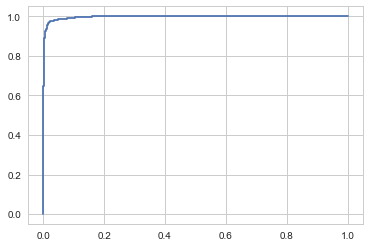

In [80]:
plt.plot(fpr, tpr)

### Save model

In [29]:
import pickle

In [31]:
with open("qda_goodbad.p", "wb") as f:
    pickle.dump(qda, f)

In [32]:
with open("qda_goodbad.p", "rb") as f:
    qda = pickle.load(f)

In [39]:
X[0].reshape(1, 9)

array([[  19.32861825,   74.59376488,  101.89400857,  118.23544433,
         136.80332436,  161.93016993,  225.54908553,  231.38313609,
         234.0563475 ]])

In [4]:
color1= np.array([19.32861825,   74.59376488,  101.89400857])
color2=np.array([118.23544433, 136.80332436,  161.93016993])
color3=np.array([225.54908553,  231.38313609, 234.0563475])

In [45]:
np.hstack([color1, color2, color3])

array([  19.32861825,   74.59376488,  101.89400857,  118.23544433,
        136.80332436,  161.93016993,  225.54908553,  231.38313609,
        234.0563475 ])

In [40]:
qda.predict_proba(X[0].reshape(1, 9))

array([ 1.])

In [85]:
y_pred

array([1., 1., 1., ..., 0., 0., 0.])

In [86]:
import pickle
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [87]:
def qda_goodbad(color1, color2, color3):
    '''
    Predict Good/Bad codis using qda
    input :  color1(RGB), color2(RGB), color3(RGB)
    output : good probabilities
    '''
    
    # load model
    with open("model/qda_goodbad.p", "rb") as f:
        qda = pickle.load(f)
    
    # change color
    color1 = np.array(color1)
    color2 = np.array(color2)
    color3 = np.array(color3)
    color = np.hstack([color1, color2, color3])
    
    # predict
    prob_good = qda.predict_proba(color.reshape(1, 9))[0]
    
    return prob_good[1]

In [88]:
def hex_to_rgb(h): 
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2 ,4))

from PIL import Image, ImageDraw 
def view_color(rgb):
    w, h = 5, 1

    img = Image.new('RGB',(w,h), rgb)

    plt.grid(False)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [89]:
color1= np.array([19.32861825,   74.59376488,  101.89400857])
color2=np.array([118.23544433, 136.80332436,  161.93016993])
color3=np.array([225.54908553,  231.38313609, 234.0563475])

In [90]:
qda_goodbad(color1, color2, color3)

0.9987228069348237

In [91]:
c1 = hex_to_rgb('#232426')
c2 = hex_to_rgb('#1b7e6d')
c3 = hex_to_rgb('#d1cfc9')
c1, c2, c3
qda_goodbad(c1, c2, c3)
#232426,#1b7e6d,#d1cfc9

0.02533714065623597